# Imports

First, a few imports. You may have one or two things to install first. 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from tqdm import tqdm
from wpca import PCA, WPCA, EMPCA
from astropy.timeseries import LombScargle
import random
import pacmap
import matplotlib
#from scipy import stats
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
#from scipy.stats.stats import pearsonr 
import sys

#from astropy.table import Table
#from collections import Counter



# Load Data

One will load all the lbl data of our star. In this example, we will load every lbl dLWs data of the star EV Lac

In [3]:
target = 'EV_Lac'
Prot = 4.3615
template = target
target = target + '_' + template

cwd = "/media/paul/One Touch11/wapiti_workflow" ## base work directory
sys.path.append(os.path.abspath("/media/paul/One Touch11/wapiti_workflow"))
from wapiti import wapiti_tools, wapiti

In [4]:
path = cwd + '/lblrv/' + target #### PATH TO CHANGE ####
os.chdir(path)
d2vs_all = []
dd2vs_all  = []
times_lbl = []
berv = []
snrs = []
for (root, dirs, file) in os.walk(path):
    for f in tqdm(sorted(file)):
        if 'lbl.fits' in f:
            nthfile = fits.open(f, memmap=False)
            times_lbl.append(nthfile[0].header['BJD'])
            berv.append(nthfile[0].header['BERV'])
            d2vs_all.append(nthfile[1].data['d2v'])
            dd2vs_all.append(nthfile[1].data['sd2v'])
            snrs.append(nthfile[0].header['SPEMSNR'])
            nthfile.close()

d2vs_all  = np.array(d2vs_all)
dd2vs_all = np.array(dd2vs_all)
times_lbl = np.array(times_lbl)
berv = np.array(berv)
snrs = np.array(snrs)

100%|██████████| 699/699 [02:39<00:00,  4.37it/s]


# Preprocess
Then, there is some steps to pre-process the data. The first one is to bin per night the data

## Night Binn

In [7]:
d2vs_binned = []
dd2vs_binned = []

for idx in tqdm(range(d2vs_all.shape[1]), leave=False):

    time_binned, d2v, dd2v = wapiti_tools.night_bin(times_lbl, d2vs_all[:, idx], dd2vs_all[:, idx])
    d2vs_binned.append(d2v)
    dd2vs_binned.append(dd2v)

d2vs_binned = np.array(d2vs_binned).T
dd2vs_binned = np.array(dd2vs_binned).T
_, berv = wapiti_tools.night_bin(times_lbl, berv)

the second step is to remove all faulty lines. Here, we defined faulty lines as lines with more than half of the measurements missing 

## Remove faulty lines 

In [10]:
print('Number of lines before rejection: ', d2vs_binned.shape[1])
valid = wapiti_tools.compute_valid_lines(d2vs_binned.T, time_binned, 0.5)
print('Number of lines after rejection: ', d2vs_binned[:, valid].shape[1])

time_used = np.copy(time_binned)
berv_used = berv
d2vs_used = np.copy(d2vs_binned)[:, valid] 
dd2vs_used = np.copy(dd2vs_binned)[:, valid]

Number of lines before rejection:  21473
Number of lines after rejection:  15381


# a first PCA before any filtering 

Lets do a first PCA on these data to see what is coming out of these 

In [12]:
# Create masked arrays for the used RVs and RV uncertainties, masking any NaN values
ma_d2vs = np.ma.MaskedArray((d2vs_used.T), mask=np.isnan((d2vs_used.T)))
ma_dd2vs = np.ma.MaskedArray((dd2vs_used.T), mask=np.isnan((dd2vs_used.T)))

# Compute the average and variance of the used RVs and RV uncertainties using the masked arrays
average = np.ma.average(ma_d2vs, weights=1/ma_dd2vs**2, axis=1)
variance = np.ma.average((ma_d2vs-average.reshape(-1, 1))**2, weights=1/ma_dd2vs**2, axis=1)

# Reshape the averages and standard deviations into column vectors
mean_d2vs = average.data.reshape(-1, 1)
std_d2vs = np.sqrt(variance.data.reshape(-1, 1))

# Normalize the used RVs and RV uncertainties
RV2 = (np.copy(d2vs_used.T)-mean_d2vs)/std_d2vs
dRV2 = np.copy(dd2vs_used.T)/std_d2vs

weights = 1. / dRV2 # Not a mistake - The wPCA is coded in a way that 1/dX as a weights variable here means using 1/dX² as an effective weights
weights[np.isnan(RV2)] = 0
pca_d2v = WPCA(n_components=RV2.shape[1])
pca_d2v.fit(RV2, weights=weights)

WPCA(n_components=169)

Lets also perform a weighted average on this data to compare the PCA with the over all effect 

In [13]:
d2v_0, std_d2v_0 = [], []
for idx in tqdm(range(len(time_used)), leave=False):
    d2v_temp, std_d2v_temp = wapiti_tools.odd_ratio_mean(d2vs_used[idx], dd2vs_used[idx])
    d2v_0.append(d2v_temp)
    std_d2v_0.append(std_d2v_temp)
d2v_0, std_d2v_0 = np.array(d2v_0), np.array(std_d2v_0)

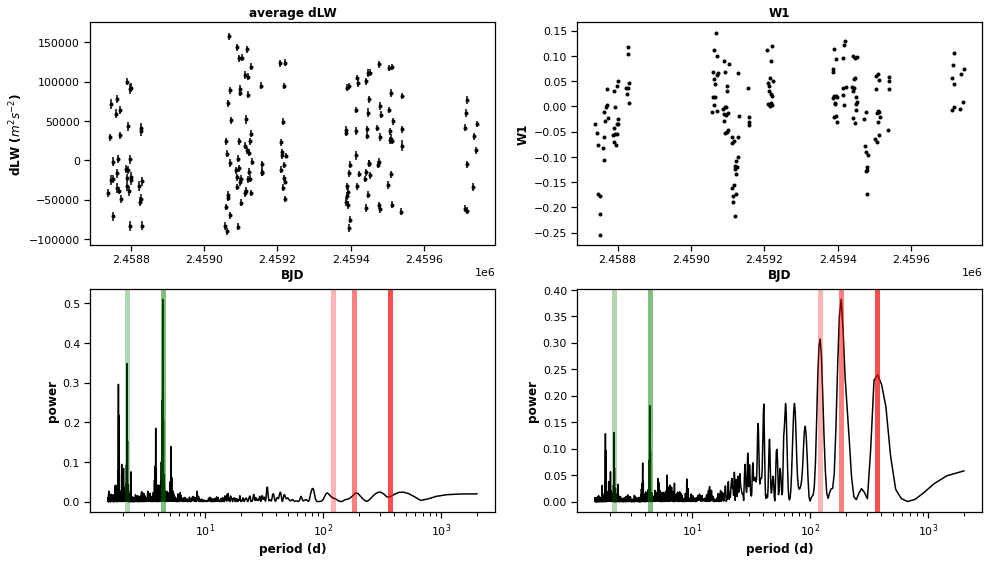

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))

ax[0, 0].errorbar(time_used, d2v_0, yerr=std_d2v_0, fmt='.k')
ax[0, 0].set_ylabel("dLW ($m^2 s^{-2}$)", size=12, weight='bold')
ax[0, 0].set_xlabel("BJD", size=12, weight='bold')
ax[0, 0].set_title("average dLW", size=12, weight='bold')

frequency, power = LombScargle(time_used, d2v_0).autopower(minimum_frequency=1/2000, maximum_frequency=1/1.5)
ax[1, 0].plot(1/frequency, power, 'k')
ax[1, 0].set_ylabel("power", size=12, weight='bold')
ax[1, 0].set_xlabel("period (d)", size=12, weight='bold')
ax[1, 0].set_xscale('log')
ax[1, 0].axvline(365.25, color='r', alpha=0.7, linewidth=5)
ax[1, 0].axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
ax[1, 0].axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
ax[1, 0].axvline(Prot, color='g', alpha=0.5, linewidth=5)
ax[1, 0].axvline(Prot/2, color='g', alpha=0.3, linewidth=5)


ax[0, 1].plot(time_used, pca_d2v.components_[0], 'k.')
ax[0, 1].set_ylabel('W1', size=12, weight='bold')
ax[0, 1].set_xlabel("BJD", size=12, weight='bold')
ax[0, 1].set_title("W1", size=12, weight='bold')

frequency, power = LombScargle(time_used, pca_d2v.components_[0]).autopower(minimum_frequency=1/2000, maximum_frequency=1/1.5)
ax[1, 1].plot(1/frequency, power, 'k')
ax[1, 1].set_ylabel("power", size=12, weight='bold')
ax[1, 1].set_xscale('log')
ax[1, 1].axvline(365.25, color='r', alpha=0.7, linewidth=5)
ax[1, 1].axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
ax[1, 1].axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
ax[1, 1].axvline(Prot, color='g', alpha=0.5, linewidth=5)
ax[1, 1].axvline(Prot/2, color='g', alpha=0.3, linewidth=5)
ax[1, 1].set_xlabel("period (d)", size=12, weight='bold')

plt.show()

As we can see, if the averaged time series shows clearly the rotational modulation, the first component of the PCA seems to be polluted by a one year signal very charcteristic of a telluric contamination. 

Because of this variability, the effect of this telluric contamination might not be immediately dominant in the overall time series of $dLW$ when averaged. PCA is, however, more sensitive to that kind of variation as demonstrated in Ould-Elhkim et al. in prep. It has been designed especially for the purpose of unveiling the main source of variations over multiple time series. Thus, the first PCA component of $dLW$, $W_1$, is more sensitive to the tellurics contamination. We will then have to filter this telluric contamination

# The SPCAndie filtering technique

## Step 1 - Record every lbl periodograms

The telluric contamination does not leave a specific imprint on the average $dLW$ time series, due to the differences in phase of its imprint and its time variability. However, the contaminating lines are shifted back and forth (in the reference frames of the stellar lines) at a specific period, being the orbital period of the Earth around the Sun. We then retrieve this periodicity and their harmonics in the Lomb-Scargle (LS) periodograms \citep{Periodogram} of the signal of the contaminated lines. If we are looking for specific patterns to detect and eliminate contaminated lines, switching to the frequency space is more convenient. We thus compute the LS-periodograms of the $dLW$ signal for each individual line. In this context, we expect that contaminated lines will induce peaks in the fundamental and harmonics of a one-year signal in their $dLW$ periodograms, regardless of the phase or the specific pattern of that signal. Simultaneously, the embedded activity signal is expected to exhibit peaks at the fundamental and harmonics of the stellar rotation period, with varying strength depending on the line's sensitivity to the magnetic field. 

We compute then, for every single lines, the LS-periodogram of the dLW signal, using the same frequency grid: 

In [23]:
period_grid = np.logspace(np.log(1.1), 3, 1000)
new_freq = 1/period_grid
frequency = new_freq # periodogram frequency grid

def periodo(ind, X, dX, t, show = False):
    t, dlw, sdlw = popnan(ind, X, dX, t)
    ls = LombScargle(t, dlw, sdlw)
    power = ls.power(frequency)
    max_freq = frequency[np.argmax(power)]
    max_pow = np.max(power)
    max_fap = -np.log(ls.false_alarm_probability(max_pow))
    return(power, 1/max_freq, max_pow, max_fap)

def popnan(ind, X, dX, t):
    Xout = X[ind, np.invert(np.isnan(X[ind]))]
    tout = t[np.invert(np.isnan(X[ind]))]
    dXout = dX[ind, np.invert(np.isnan(X[ind]))]
    return(tout, Xout, dXout)


In [24]:
powers = np.zeros((d2vs_used.shape[1], len(period_grid)))
mf = np.zeros(d2vs_used.shape[1])
mp = np.zeros(d2vs_used.shape[1])
mfap = np.zeros(d2vs_used.shape[1])
for i in tqdm(range(d2vs_used.shape[1])):
    p, m, mmp, f = periodo(i, d2vs_used.T, dd2vs_used.T, time_used)
    powers[i] = p
    mf[i] = m
    mfap[i] = f
    mp[i] = mmp


100%|██████████| 15381/15381 [01:19<00:00, 192.33it/s]


## Step 2 - Clustering 

For a better visualisation of all the lines, we apply a clustering algorithm to the obtained LBL periodograms. Clustering algorithms are dimensional reduction tools, enabling the visualization of N-dimensional data in a 2D map. These algorithms are designed in a way that measurements with closely aligned properties in the original N-dimensional space will remain nearby in the final map. Consequently, this allows for the spatial disentanglement of data based on their distribution in the final map.

In this specific framework, we expect contaminated lines to exhibit similar periodograms with peaks at one year or harmonics, thereby staying within the same region on the final map. Similarly, lines primarily influenced by the stellar activity signal are expected to generate power at the rotation period and harmonics, positioning them in another distinct area. The lines that are not affected by any of those phenomena will probably form another cluster in an intermediate area (and lines with other spurious signals will form more distinct clusters, etc.). Consequently, we can segment the resulting map to effectively distinguish telluric-contaminated lines from those showing activity.

In [25]:
def PacMapDisp(X, n_neighbors=10, MN_rate=0.5, FP_rate=2.0):
    random.seed(110)
    X = X.reshape(X.shape[0], -1)
    # Initialize the pacmap instance
    # Setting n_neighbors to "None" leads to an automatic parameter selection
    # choice shown in "parameter" section of the README file.
    # Notice that from v0.6.0 on, we rename the n_dims parameter to n_components.
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors, MN_ratio=MN_rate, FP_ratio=FP_rate, random_state = 110, apply_pca = True)
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(X, init="pca")
    # visualize the embedding
    fig = plt.figure(figsize=(16,10))
    scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="nipy_spectral", c=mf, s=10*mfap, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(label='Period [d]')
    cb.set_label(label='Period [d]', size='large', weight='bold')
    cb.ax.tick_params(labelsize='large')
    handles, labels = scatter.legend_elements(prop='sizes', alpha = 0.6)
    plt.legend(handles, labels, title = '$- 10 logFAP_{max}$', prop={'size':12, 'weight':'bold'})   
    plt.axis('off')
    plt.show()
    return(X_transformed)

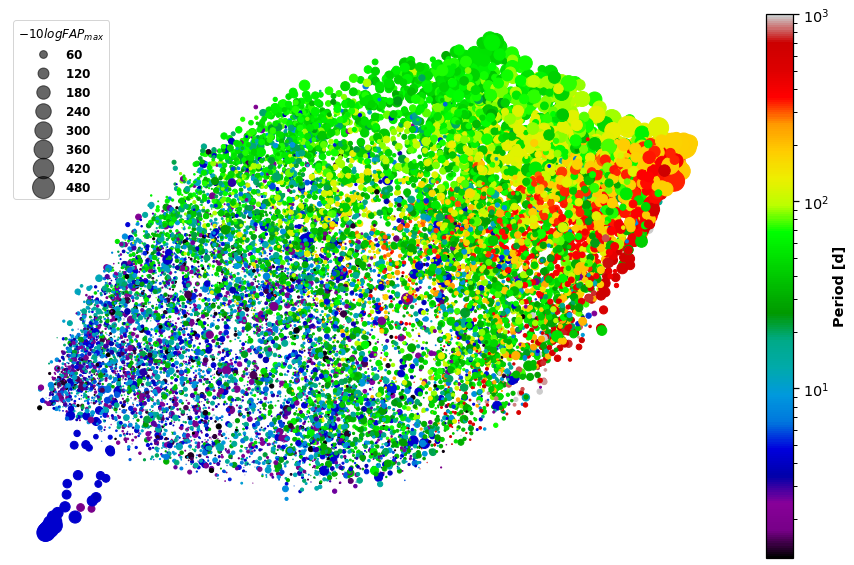

In [26]:
PacMap_map = PacMapDisp(powers)

## Step 3 - SVM 

In this map, lines dominated by a width modulation that correspond to the rotation period (4.3615 d, in dark-blue) are predominantly situated on the left side of the figure. There is even a distinct cluster representing lines influenced solely by the injected stellar activity and not affected by other spurious signals, which is noticeably shifted away from the main cluster. One will attribute the "activity" class to the lines which are dominated by this rotational modulation (with an error window of $\pm 5 \%$ to address possible differential rotation and error-bars in the rotation period given in the literature). In practical, we will also select lines with modulations at Prot/2 to address cases where the activity signal manifest variations at the first harmonic of the rotation period as well.

On the other hand, lines dominated by a one-year signal or harmonics (1 yr $\rightarrow$ red; 1/2 yr $\rightarrow$ orange; 1/3 yr $\rightarrow$ yellow; etc.) are more concentrated on the right side. One will attribute the class "telluric" to those lines (still with this $\pm 5 \%$ window). The color codes only the period of the highest peak in the periodogram, but several relatively clear signals could coexist for some lines. This explains why the two different predetermined populations overlap with each other. The size of the points represents the relative power of that strongest signal. Lines that do not fall into either of these two classes are temporarily not categorized. In our example, initially, 594 lines are labeled in the activity group, while 1091 are in the telluric group.


One will also attribute a weight to each pre-selected point depending on the dominant signal power. Then we will compensate the over-representation of the telluric sub-set by multiplying the weights of the activity class by 1091/594. 

In [28]:
def select_per(Per, mxfq):
    U = Per * 0.05
    indlw = []
    for i in range(len(mxfq)):
        if mxfq[i]>Per-U and mxfq[i]<Per+U:
            indlw.append(i)
    return(indlw)

an = 365.25

Pac_an_1  = PacMap_map[select_per(an, mf)]
sample_weight_an_1 = mp[select_per(an, mf)]
size_an_1 = mfap[select_per(an, mf)]
Pac_an_2  = PacMap_map[select_per(an/2, mf)]
sample_weight_an_2 = mp[select_per(an/2, mf)]
size_an_2 = mfap[select_per(an/2, mf)]
Pac_an_3  = PacMap_map[select_per(an/3, mf)]
sample_weight_an_3 = mp[select_per(an/3, mf)]
size_an_3 = mfap[select_per(an/3, mf)]
#Pac_an_4  = PacMap_map[select_per(an/4, mf)]
Pac_prot_1  = PacMap_map[select_per(Prot, mf)]
sample_weight_prot_1 = mp[select_per(Prot, mf)]
size_prot_1 = mfap[select_per(Prot, mf)]
Pac_prot_2  = PacMap_map[select_per(Prot/2, mf)]
sample_weight_prot_2 = mp[select_per(Prot/2, mf)]
size_prot_2 = mfap[select_per(Prot/2, mf)]
#Pac_moon  = PacMap_map[select_per(28, mf)]
#Pac_70 = PacMap_map[select_per(an/5, mf)]

Pac_prot = np.concatenate((Pac_prot_1, Pac_prot_2))
sample_weight_prot = np.concatenate((sample_weight_prot_1, sample_weight_prot_2))
size_prot = np.concatenate((size_prot_1, size_prot_2))
Pac_an   = np.concatenate((Pac_an_1, Pac_an_2, Pac_an_3))
sample_weight_an = np.concatenate((sample_weight_an_1, sample_weight_an_2, sample_weight_an_3))
size_an   = np.concatenate((size_an_1, size_an_2, size_an_3))

print(Pac_prot.shape)
print(Pac_an.shape)
weight_ratio = Pac_an.shape[0]/Pac_prot.shape[0]

class_id = np.concatenate((np.zeros_like(Pac_prot.T[0]), np.ones_like(Pac_an.T[0])))
Pac_split = np.concatenate((Pac_prot, Pac_an))
sample_weight = np.concatenate((sample_weight_prot*weight_ratio, sample_weight_an))
size_split = np.concatenate((size_prot*weight_ratio, size_an))

(594, 2)
(1091, 2)


Those two pre-defined populations, the acitve and telluric-polluted lines (purple and yellow on the next figure), will serve as a training step for a SVM separation.

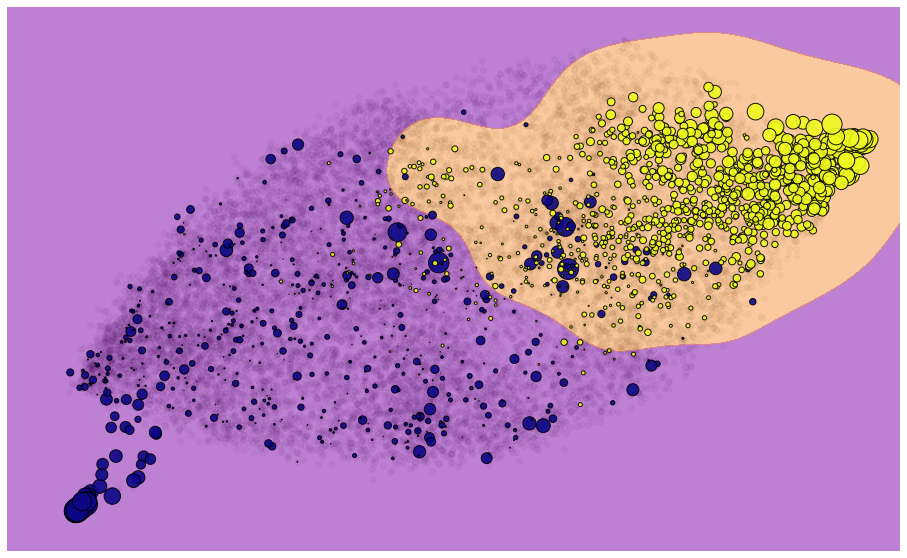

In [29]:
def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-10, 11, 500), np.linspace(-7, 7, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, levels=1, alpha=0.5, cmap=plt.cm.plasma)
    axis.scatter(
        Pac_split[:, 0],
        Pac_split[:, 1],
        c=class_id,
        s=10 * size_split,
        alpha=0.9,
        cmap=plt.cm.plasma,
        edgecolors="black",
    )
    axis.axis("off")
    axis.set_title(title)
    
# Fit the model
# This other model takes into account some dedicated sample weights.
clf_weights = svm.SVC(kernel='rbf', gamma='auto')
clf_weights.fit(Pac_split, class_id, sample_weight=sample_weight)


fig, axes = plt.subplots( 1, 1, figsize=(16, 10))
axes.scatter(PacMap_map[:,0], PacMap_map[:,1], c='k', alpha = 0.05)
plot_decision_function(clf_weights, sample_weight, axes, "")
plt.show()
## Attribute a class for every lines
weights_predi = clf_weights.predict(PacMap_map)


The SVM, applied to this subset, did find what it seems to be the perfect separation between the two clouds of points, with in purple the area dominated by the activity and in yellow the area dominated by the telluric-polution. 

In the following, we will simply discard all the lines that are in the telluric-contaminated area. 

In [30]:
d2v_filtr  = d2vs_used.T[weights_predi == 0].T
sd2v_filtr = dd2vs_used.T[weights_predi == 0].T
print('# line filtr = ', d2v_filtr.shape)

# line filtr =  (169, 10182)


## Re-run PCA once filtered 

We will then re-compute the PCA on the remaining lines that are all in the activity area. 

In [31]:
#d2v 
ma_d2v_filtr  = np.ma.MaskedArray(d2v_filtr.T, mask=np.isnan(d2v_filtr.T))
ma_sd2v_filtr = np.ma.MaskedArray(sd2v_filtr.T, mask=np.isnan(sd2v_filtr.T))
avg_d2v_filtr = np.ma.average(ma_d2v_filtr, weights=1/ma_sd2v_filtr**2, axis=1)
std_d2v_filtr = np.ma.average((ma_d2v_filtr-avg_d2v_filtr.reshape(-1,1))**2, weights=1/ma_sd2v_filtr**2, axis=1)
avg_d2v_filtr = avg_d2v_filtr.data.reshape(-1,1)
std_d2v_filtr = np.sqrt(std_d2v_filtr.data.reshape(-1,1))
RV2_filtr  = (np.copy(d2v_filtr.T) - avg_d2v_filtr)/std_d2v_filtr
dRV2_filtr = np.copy(sd2v_filtr.T)/std_d2v_filtr
weights_d2v_filtr = 1. / dRV2_filtr
weights_d2v_filtr[np.isnan(RV2_filtr)] = 0
pca_d2v_filtr = WPCA(n_components=RV2_filtr.shape[1])
pca_d2v_filtr.fit(RV2_filtr, weights=weights_d2v_filtr)

WPCA(n_components=169)

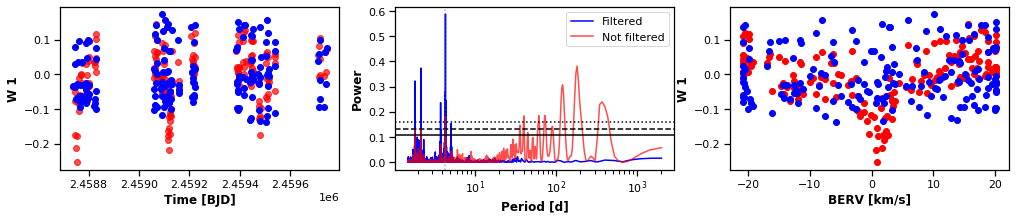

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(17, 3))

ax[0].plot(time_used, pca_d2v.components_[0], 'ro', alpha=0.7)
ax[0].plot(time_used, pca_d2v_filtr.components_[0], 'bo')
ax[0].set_ylabel(f'W {1}', size=12, weight='bold')
# Set the x-axis label
ax[0].set_xlabel('Time [BJD]', size=12, weight='bold')


frequency, power = LombScargle(time_used, pca_d2v_filtr.components_[0]).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'b', label='Filtered')
frequency, power = LombScargle(time_used, pca_d2v.components_[0]).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'r', alpha=0.7, label='Not filtered')
ax[1].set_ylabel("power")
ax[1].set_xscale('log')
ls = LombScargle(time_used, pca_d2v_filtr.components_[0])
fap = ls.false_alarm_level(0.1)
ax[1].axhline(fap, linestyle='-', color='k')
fap = ls.false_alarm_level(0.01)
ax[1].axhline(fap, linestyle='--', color='k')
fap = ls.false_alarm_level(0.001)
ax[1].axhline(fap, linestyle=':', color='k')
ax[1].axvline(Prot, linestyle=':', alpha=0.5)
ax[1].set_xlabel('Period [d]', size=12, weight='bold')
ax[1].set_ylabel('Power', size=12, weight='bold')
ax[1].legend()


ax[2].plot(berv_used, pca_d2v.components_[0], 'ro')  
ax[2].plot(berv_used, pca_d2v_filtr.components_[0], 'bo')
ax[2].set_ylabel(f'W {1}', size=12, weight='bold')
# Set the x-axis label
ax[2].set_xlabel('BERV [km/s]', size=12, weight='bold')

plt.show()

Aaaand TADAAAA ! 

We succesfully removed the telluric signal from our first component of the PCA. 